# Reddit Classification 

## Notebook 4 of 5 - (Vectorisation + Modelling) Part 2 of 2

# Importing Libraries

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
sns.set_theme()

In [21]:
anxiety_depression = pd.read_csv('datasets/anxiety_depression.csv')

In [22]:
anxiety_depression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29907 entries, 0 to 29906
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   is_anxiety         29907 non-null  int64 
 1   title_text         29907 non-null  object
 2   date_time          29907 non-null  object
 3   title_text_re      29907 non-null  object
 4   status_length      29907 non-null  int64 
 5   status_word_count  29907 non-null  int64 
 6   day                29907 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 1.6+ MB


# Pipeline Vectorisation + Modelling 

Pipeline 3 = TfidfVectorizer() + RandomForest  
Pipeline 4 = TfidfVectorizer() + Pycaret Model

In [23]:
# Recall that a new column was created after doing Regex, thus new 'X'
X2 = anxiety_depression['title_text_re']
y = anxiety_depression['is_anxiety']

In [24]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X2,y,stratify=y,random_state=42)

In [25]:
# The dataset is balanced 
y_test.value_counts(normalize=True)

1    0.505283
0    0.494717
Name: is_anxiety, dtype: float64

In [26]:
# Stemming
class StemmTokenizer(object):
    def __init__(self):
        self.wnl = PorterStemmer()
    def __call__(self, articles):
        return [self.wnl.stem(t) for t in word_tokenize(articles)]

In [27]:
# Using the custom stopwords from notebook 2
stop_words = frozenset(['removed','deleted','anxiety','anxious','depression','depressed'])
custom_stop_words = stop_words.union(TfidfVectorizer(stop_words = 'english').get_stop_words())

## Pipeline 3: Random Forest Model
- Using the best parameters evaluated from pipeline 2 for the vectorizer to use in RandomForest Model.

In [28]:
# Instantiate the Vectorizers
tfidf = TfidfVectorizer(max_df = 0.9, 
                        max_features = 3000, 
                        min_df = 2, 
                        ngram_range= (1,1), 
                        stop_words = custom_stop_words, 
                        tokenizer = StemmTokenizer())

In [29]:
# Fit the vectorizer on our corpus and transform it.
X_train_tfidf = tfidf.fit_transform(X_train)

In [30]:
# After vectorization
X_train_tfidf

<22430x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 1050277 stored elements in Compressed Sparse Row format>

In [31]:
# Vectorize the X_test
X_test_tfidf = tfidf.transform(X_test)

In [32]:
# Instantiate the RandomForestClassifier
rf = RandomForestClassifier()

In [33]:
%%time
rf_params = {
    'n_estimators': [100, 150, 200], # iterating over different number of trees in the forest
    'max_depth': [3, 4, 5], # iterating over a defined set of max depth of tree. For None, the nodes are expanded until all leaves are pure
}
gs3 = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=10)
gs3_fit = gs3.fit(X_train_tfidf, y_train)
%store gs3_fit
%store gs3

print(gs3.best_score_)
gs3.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START max_depth=3, n_estimators=100...............................
[CV 1/5; 1/9] END max_depth=3, n_estimators=100;, score=0.866 total time=   0.5s
[CV 2/5; 1/9] START max_depth=3, n_estimators=100...............................
[CV 2/5; 1/9] END max_depth=3, n_estimators=100;, score=0.855 total time=   0.5s
[CV 3/5; 1/9] START max_depth=3, n_estimators=100...............................
[CV 3/5; 1/9] END max_depth=3, n_estimators=100;, score=0.863 total time=   0.5s
[CV 4/5; 1/9] START max_depth=3, n_estimators=100...............................
[CV 4/5; 1/9] END max_depth=3, n_estimators=100;, score=0.872 total time=   0.5s
[CV 5/5; 1/9] START max_depth=3, n_estimators=100...............................
[CV 5/5; 1/9] END max_depth=3, n_estimators=100;, score=0.867 total time=   0.5s
[CV 1/5; 2/9] START max_depth=3, n_estimators=150...............................
[CV 1/5; 2/9] END max_depth=3, n_estimators=150;,

{'max_depth': 5, 'n_estimators': 200}

In [34]:
# Accuracy score of train on pipeline 3
gs3.score(X_train_tfidf, y_train)

0.8794917521176995

In [35]:
# Accuracy score of test on pipeline 3
gs3.score(X_test_tfidf, y_test)

0.872274976594891

In [36]:
# Get the predictions from X_test
predictions3 = gs3.predict(X_test_tfidf)

In [37]:
# Get the confusion matrix from the predicted labels and compared to true labels
confusion_matrix(y_test, predictions3)

array([[3412,  287],
       [ 668, 3110]], dtype=int64)

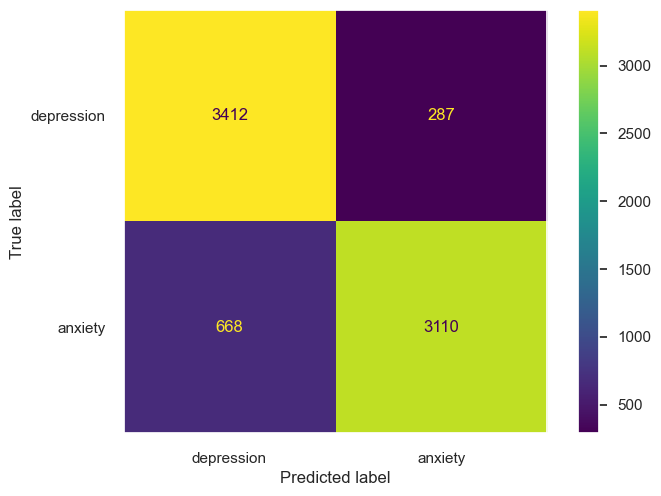

In [38]:
# Plotting the confusion matrix
cm = confusion_matrix(y_test, predictions3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['depression', 'anxiety'])
disp.plot()
plt.grid(False);

- The train score for pipeline 3 is at 87.9% and the test score at 87.2% which the train and test score is much closer than the base model but test score is lower than the base model. 
- Pipeline 3 has the lowest accuracy score than the rest of the models.

## Pycaret Models
- Using the best parameters evaluated from pipeline 2 for the vectorizer was used together with the pycaret model for evaluation.

In [39]:
# Instantiate the Vectorizers
tfidf2 = TfidfVectorizer(max_df = 0.9, 
                        max_features = 3000, 
                        min_df = 2, 
                        ngram_range= (1,1), 
                        stop_words = custom_stop_words, 
                        tokenizer = StemmTokenizer())

In [40]:
# Get the train data through the vectorizer and set it as a dataframe
X_train_tfidf_df = pd.DataFrame(tfidf2.fit_transform(X_train.values).todense(),columns = tfidf2.get_feature_names_out())

In [41]:
# Get the test data through the vectorizer and set it as a dataframe
X_test_tfidf_df = pd.DataFrame(tfidf2.transform(X_test.values).todense(),columns = tfidf2.get_feature_names_out())

In [42]:
# Concat the train data as a single dataframe to use it in pycaret model
pycaret_df = pd.concat([X_train_tfidf_df, y_train.reset_index(drop=True)], axis=1)

In [43]:
pycaret_df.shape

(22430, 3001)

In [44]:
pycaret_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22430 entries, 0 to 22429
Columns: 3001 entries, abandon to is_anxiety
dtypes: float64(3000), int64(1)
memory usage: 513.6 MB


In [45]:
# Since pycaret seperates features and target we will set the features to the vectorized columns.
vectorized_cols = list(X_train_tfidf_df.columns)

In [46]:
pycaret_df['is_anxiety']

0        0
1        0
2        1
3        1
4        1
        ..
22425    0
22426    1
22427    1
22428    1
22429    1
Name: is_anxiety, Length: 22430, dtype: int64

In [47]:
from pycaret.classification import *

In [48]:
reg_experiment = setup(data = pycaret_df,
                       numeric_features = vectorized_cols,
                       target = 'is_anxiety',
                       use_gpu = True,
                       session_id=42, 
                       experiment_name='anxiety_depression_project_3'
                       )

,Description,Value
0,Session id,42
1,Target,is_anxiety
2,Target type,Binary
3,Original data shape,"(22430, 3001)"
4,Transformed data shape,"(22430, 3001)"
5,Transformed train set shape,"(15700, 3001)"
6,Transformed test set shape,"(6730, 3001)"
7,Numeric features,3000
8,Preprocess,True
9,Imputation type,simple


In [49]:
best_model = compare_models(n_select = 20)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9017,0.9609,0.8843,0.9182,0.9009,0.8035,0.8041,7.6120
lightgbm,Light Gradient Boosting Machine,0.9016,0.9598,0.8874,0.9152,0.9011,0.8032,0.8036,7.0750
svm,SVM - Linear Kernel,0.8976,0.0000,0.8733,0.9203,0.8959,0.7952,0.7967,2.9780
rf,Random Forest Classifier,0.8937,0.9515,0.8810,0.9060,0.8933,0.7874,0.7878,7.5170
et,Extra Trees Classifier,0.8915,0.9472,0.8859,0.8980,0.8919,0.7829,0.7831,10.9260
ridge,Ridge Classifier,0.8882,0.0000,0.8631,0.9109,0.8863,0.7764,0.7776,2.2700
gbc,Gradient Boosting Classifier,0.8871,0.9514,0.8599,0.9116,0.8850,0.7744,0.7757,55.8910
ada,Ada Boost Classifier,0.8754,0.9432,0.8734,0.8792,0.8763,0.7508,0.7509,14.3070
lda,Linear Discriminant Analysis,0.8632,0.9341,0.8438,0.8805,0.8617,0.7266,0.7273,16.7560
dt,Decision Tree Classifier,0.8276,0.8286,0.8244,0.8329,0.8286,0.6553,0.6554,12.8300


In [52]:
best_model = best_model
%store best_model

Stored 'best_model' (list)


In [53]:
# Best parameters for Logistic Regression
best_model[0]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
# Creating the best model after evaluating through pycaret
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9019,0.9600,0.8852,0.9176,0.9012,0.8039,0.8044
1,0.9006,0.9574,0.8714,0.9275,0.8986,0.8014,0.8029
2,0.9000,0.9588,0.8840,0.9151,0.8993,0.8000,0.8005
3,0.9185,0.9705,0.9054,0.9313,0.9182,0.8370,0.8373
4,0.8987,0.9620,0.8827,0.9138,0.8980,0.7975,0.7980
5,0.8936,0.9582,0.8852,0.9023,0.8937,0.7873,0.7874
6,0.9102,0.9652,0.8966,0.9234,0.9098,0.8204,0.8208
7,0.8975,0.9601,0.8827,0.9115,0.8969,0.7949,0.7954
8,0.8968,0.9582,0.8690,0.9225,0.8949,0.7937,0.7951


In [55]:
# Optimising the hyperparameters of the LogReg model
tuned_log_reg = tune_model(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9025,0.9599,0.8865,0.9178,0.9019,0.8051,0.8056
1,0.9006,0.9581,0.8764,0.9230,0.8991,0.8014,0.8024
2,0.8981,0.9586,0.8802,0.9148,0.8972,0.7962,0.7968
3,0.9210,0.9698,0.9067,0.9350,0.9206,0.8421,0.8425
4,0.9019,0.9628,0.8852,0.9176,0.9012,0.8039,0.8044
5,0.8962,0.9584,0.8865,0.9059,0.8961,0.7924,0.7926
6,0.9006,0.9654,0.8840,0.9163,0.8999,0.8013,0.8018
7,0.8981,0.9608,0.8827,0.9126,0.8974,0.7962,0.7967
8,0.8975,0.9576,0.8703,0.9226,0.8957,0.7950,0.7963


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [56]:
# Check the best params from the tuned log_reg
tuned_log_reg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The tuned log_reg has similar parameters from the best_model of LogReg.

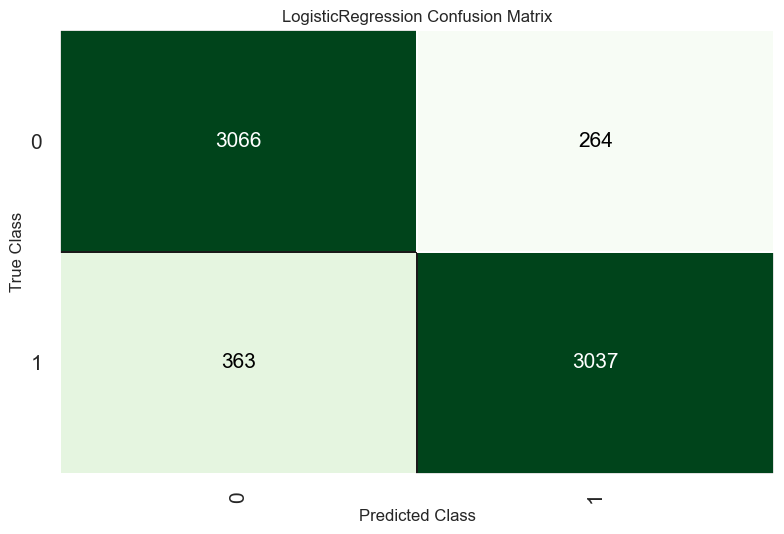

In [57]:
# Look into the confusion matrix of the pycaret-train set versus pycaret-test set (hold-out set)
plot_model(tuned_log_reg, plot = 'confusion_matrix')

In [58]:
# Pycaret-test set (hold out set) on the Pycaret trained model for LogReg
predict_model(tuned_log_reg)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9068,0.9620,0.8932,0.9200,0.9064,0.8137,0.8141


,abandon,abdomen,abdomin,abil,abl,abnorm,abort,abov,abroad,absenc,...,yr,zap,zero,zoloft,zombi,zone,zoom,is_anxiety,prediction_label,prediction_score
15700,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,1,0.9795
15701,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,1,0.9991
15702,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,0,0.8592
15703,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,1,0.9889
15704,0.0,0.000000,0.0,0.000000,0.091602,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,1,0.7098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22425,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,0,0.9912
22426,0.0,0.000000,0.0,0.000000,0.026062,0.0,0.0,0.043377,0.0,0.0,...,0.0,0.0,0.086924,0.0,0.0,0.0,0.0,1,0,0.6080
22427,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,1,0.8330
22428,0.0,0.140314,0.0,0.108733,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,1,0.9978


In [59]:
# Training the entire pycaret_df which includes the hold_out set
final_lr = finalize_model(tuned_log_reg)

In [60]:
final_lr

Pipeline(memory=Memory(location=C:\Users\CALERL~1\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['abandon', 'abdomen', 'abdomin',
                                             'abil', 'abl', 'abnorm', 'abort',
                                             'abov', 'abroad', 'absenc',
                                             'absent', 'absolut', 'absorb',
                                             'abt', 'abus', 'academ', 'accept',
                                             'access', 'accid', 'accident',
                                             'accommod', 'accompani',
                                             'accompli...
                 TransformerWrapper(exclude=[], include=None,
                                    transformer=VarianceThreshold(threshold=0))),
                ('actual_estimator',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [61]:
# Check the prediction from the finalised model of LogReg
predict_model(final_lr)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9264,0.9727,0.9121,0.9406,0.9261,0.8529,0.8533


,abandon,abdomen,abdomin,abil,abl,abnorm,abort,abov,abroad,absenc,...,yr,zap,zero,zoloft,zombi,zone,zoom,is_anxiety,prediction_label,prediction_score
15700,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,1,0.9835
15701,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,1,0.9995
15702,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,0,0.8210
15703,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,1,0.9931
15704,0.0,0.000000,0.0,0.000000,0.091602,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,1,0.7529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22425,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,0,0.9937
22426,0.0,0.000000,0.0,0.000000,0.026062,0.0,0.0,0.043377,0.0,0.0,...,0.0,0.0,0.086924,0.0,0.0,0.0,0.0,1,0,0.5293
22427,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,1,0.8611
22428,0.0,0.140314,0.0,0.108733,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,1,0.9989


In [62]:
# Concat the vectorized X_test in a dataframe with the y_test values
test_df = pd.concat([X_test_tfidf_df, y_test.reset_index(drop=True)], axis=1)

In [63]:
test_df.shape

(7477, 3001)

In [64]:
# Check that is correctly concatenated
test_df.head()

,abandon,abdomen,abdomin,abil,abl,abnorm,abort,abov,abroad,absenc,...,youtu,youtub,yr,zap,zero,zoloft,zombi,zone,zoom,is_anxiety
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [65]:
# Comparing the finalized model of LogReg with the test data set
lr_pred = predict_model(final_lr, data=test_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9060,0.9613,0.8878,0.9232,0.9051,0.8120,0.8126


In [66]:
# A look into the test data, prediction_label and prediction_score
lr_pred[['is_anxiety','prediction_label','prediction_score']]

,is_anxiety,prediction_label,prediction_score
0,0,0,0.7526
1,1,1,0.9993
2,0,0,0.8161
3,1,1,0.9547
4,0,0,0.7968
...,...,...,...
7472,1,1,0.9652
7473,1,0,0.5892
7474,1,1,0.9546
7475,0,0,0.9086


- Through the evaluation of the data through Pycaret models after vectorizing, for the finalised model of LogReg has the highest accuracy score of train (0.926)/92.6% and test(0.906)/90.6%. 
- Pycaret (0.906) has higher test score than the base model(0.886) and similar scores to pipeline 2(0.906).

# Evaluation of Pipeline 3 and Pycaret

|Pipeline|Vectorizer|Estimator|Parameters for Vectorizer|Parameters for Estimator|Train|Test
|----|----|----|----|----|----|----|
|Base|CountVectorizer|Logsitic Regression|-|max_iter = 700|0.971|0.886|
|3|TFIDF|RandomForest|max_df = 0.9, max_features = 3000, min_df = 2, ngram_range: (1,1), stop_words = custom_stop_words, Tokenizer = StemmTokenizer|max_depth= 4, n_estimators= 200|0.871|0.863|
|Pycaret|TFIDF|Logistic Regression|max_df = 0.9, max_features = 3000, min_df = 2, ngram_range: (1,1), stop_words = custom_stop_words, Tokenizer = StemmTokenizer|c=1, max_iter = 1000|0.926|0.906|

In the next code notebook (Notebook 5), HuggingFace models are explored.